# Load the libraries

In [ ]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
library(RColorBrewer)
library(sva)
library(ggExtra)
source("helper_functions.R")

In [2]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed.V5.1";

# Load the necessary input

## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [3]:
cm_covs <- fread("v5.expr/v5.full.cM.immvar21.covs.txt");
colnames(cm_covs) <- sapply(colnames(cm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
covs_gene_names <- cm_covs$V1;
cm_covs <- as.matrix(cm_covs[,-1]);

th_covs <- as.matrix(fread("v5.expr/v5.full.Th.immvar21.covs.txt")[,-1]);
colnames(th_covs) <- sapply(colnames(th_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

tc_covs <- as.matrix(fread("v5.expr/v5.full.Tc.immvar21.covs.txt")[,-1]);
colnames(tc_covs) <- sapply(colnames(tc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

ncm_covs <- as.matrix(fread("v5.expr/v5.full.ncM.immvar21.covs.txt")[,-1]);
colnames(ncm_covs) <- sapply(colnames(ncm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

b_covs <- as.matrix(fread("v5.expr/v5.full.B.immvar21.covs.txt")[,-1]);
colnames(b_covs) <- sapply(colnames(b_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

nk_covs <- as.matrix(fread("v5.expr/v5.full.NK.immvar21.covs.txt")[,-1]);
colnames(nk_covs) <- sapply(colnames(nk_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

dc_covs <- as.matrix(fread("v5.expr/v5.full.cDC.immvar21.covs.txt")[,-1]);
colnames(dc_covs) <- sapply(colnames(dc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

pbmc_covs <- as.matrix(fread("v5.expr/v5.full.PBMC.immvar21.covs.txt")[,-1]);
colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_covs) <- rownames(cm_covs) <- rownames(th_covs) <- rownames(tc_covs) <- rownames(ncm_covs) <- rownames(b_covs) <- rownames(nk_covs) <-rownames(dc_covs) <- covs_gene_names;


## Load the processed expression data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [4]:
cm_expr <- fread("v5.expr/v5.full.cM.blind.expr.txt");
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
expr_gene_names <- cm_expr$V1;
cm_expr <- as.matrix(cm_expr[,-1]);

th_expr <- as.matrix(fread("v5.expr/v5.full.Th.blind.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

tc_expr <- as.matrix(fread("v5.expr/v5.full.Tc.blind.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

ncm_expr <- as.matrix(fread("v5.expr/v5.full.ncM.blind.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

b_expr <- as.matrix(fread("v5.expr/v5.full.B.blind.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

nk_expr <- as.matrix(fread("v5.expr/v5.full.NK.blind.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

dc_expr <- as.matrix(fread("v5.expr/v5.full.cDC.blind.expr.txt")[,-1]);
colnames(dc_expr) <- sapply(colnames(dc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

pbmc_expr <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(dc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(dc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
dc_expr <- dc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];


Warning message in fread("v5.expr/v5.full.cM.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.expr/v5.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.expr/v5.full.Tc.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames(

In [5]:
# expressed_genes <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.expr.genes.txt")[,-1]);

# pbmc_expr <- pbmc_expr[expressed_genes,]
# cm_expr <- cm_expr[expressed_genes,];
# ncm_expr <- ncm_expr[expressed_genes,];
# th_expr <- th_expr[expressed_genes,];
# tc_expr <- tc_expr[expressed_genes,];
# b_expr <- b_expr[expressed_genes,];
# nk_expr <- nk_expr[expressed_genes,];
# dc_expr <- dc_expr[expressed_genes,];
# expr_gene_names <- expr_gene_names[expressed_genes];

## filter samples

In [6]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")

In [7]:
## let's remove the UCSF duplicate samples for now
ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

## let's get joined_ind_pivot into the same order as pbmc_expr
joined_pivot <- joined_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];

## below also works but may not get exactly the same sample
# ucsf_samples <- grep("lupus",cm_covs[,"batch"]);
# ucsf_samples_nodups <- ucsf_samples[!duplicated(colnames(cm_expr)[ucsf_samples])];

cm_expr <- cm_expr[,ucsf_samples_nodups];
th_expr <- th_expr[,ucsf_samples_nodups];
tc_expr <- tc_expr[,ucsf_samples_nodups];
ncm_expr <- ncm_expr[,ucsf_samples_nodups];
b_expr <- b_expr[,ucsf_samples_nodups];
nk_expr <- nk_expr[,ucsf_samples_nodups];
dc_expr <- dc_expr[,ucsf_samples_nodups];
pbmc_expr <- pbmc_expr[,ucsf_samples_nodups];

cm_covs <- cm_covs[ucsf_samples_nodups,];
th_covs <- th_covs[ucsf_samples_nodups,];
tc_covs <- tc_covs[ucsf_samples_nodups,];
ncm_covs <- ncm_covs[ucsf_samples_nodups,];
b_covs <- b_covs[ucsf_samples_nodups,];
nk_covs <- nk_covs[ucsf_samples_nodups,];
dc_covs <- dc_covs[ucsf_samples_nodups,];
pbmc_covs <- pbmc_covs[ucsf_samples_nodups,];

sle_indices <- setdiff((1:ncol(pbmc_expr)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

ucsf_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("lupus",pbmc_covs[,"batch"]))
ucsf_healthy_colnames <- paste(colnames(pbmc_expr)[ucsf_healthy_indices],"_ucsf",sep="")

cm_ucsf_healthy_expr <- cm_expr[,ucsf_healthy_indices]
th_ucsf_healthy_expr <- th_expr[,ucsf_healthy_indices]
tc_ucsf_healthy_expr <- tc_expr[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr <- ncm_expr[,ucsf_healthy_indices]
b_ucsf_healthy_expr <- b_expr[,ucsf_healthy_indices]
nk_ucsf_healthy_expr <- nk_expr[,ucsf_healthy_indices]
dc_ucsf_healthy_expr <- dc_expr[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

# colnames(cm_ucsf_healthy_expr) <- colnames(th_ucsf_healthy_expr) <- colnames(tc_ucsf_healthy_expr) <- ucsf_healthy_colnames;
# colnames(ncm_ucsf_healthy_expr) <- colnames(b_ucsf_healthy_expr) <- colnames(nk_ucsf_healthy_expr) <- ucsf_healthy_colnames;
# colnames(dc_ucsf_healthy_expr) <- colnames(pbmc_ucsf_healthy_expr) <- ucsf_healthy_colnames;

broad_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("immvar", pbmc_covs[,"batch"]))
broad_healthy_colnames <- paste(colnames(pbmc_expr)[broad_healthy_indices],"_broad",sep="")

cm_broad_healthy_expr <- cm_expr[,broad_healthy_indices]
th_broad_healthy_expr <- th_expr[,broad_healthy_indices]
tc_broad_healthy_expr <- tc_expr[,broad_healthy_indices]
ncm_broad_healthy_expr <- ncm_expr[,broad_healthy_indices]
b_broad_healthy_expr <- b_expr[,broad_healthy_indices]
nk_broad_healthy_expr <- nk_expr[,broad_healthy_indices]
dc_broad_healthy_expr <- dc_expr[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]



# colnames(cm_broad_healthy_expr) <- colnames(th_broad_healthy_expr) <- colnames(tc_broad_healthy_expr) <- broad_healthy_colnames;
# colnames(ncm_broad_healthy_expr) <- colnames(b_broad_healthy_expr) <- colnames(nk_broad_healthy_expr) <- broad_healthy_colnames;
# colnames(dc_broad_healthy_expr) <- colnames(pbmc_broad_healthy_expr) <- broad_healthy_colnames;


In [8]:
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0


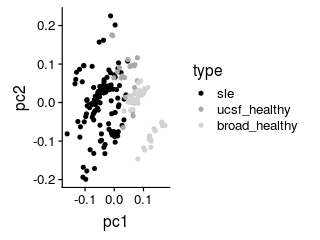

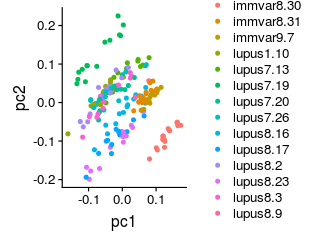

In [9]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

In [10]:
# pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(pbmc_deseq_sig_genes,rownames(pbmc_expr_std))),])

# df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
#            )
# df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# options(repr.plot.width = 4, repr.plot.height = 3)
# ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

## Load the raw counts from ```/ye/yelabstore2/10x.lupus/disease/demux.v2```

In [11]:
# ## either load only the original samples

# # cm_counts <- fread("v2.deseq/norep.noadjrace.CD14+.Monocytes.counts.txt");
# # colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # th_counts <- fread("v2.deseq/norep.noadjrace.CD4.T.cells.counts.txt");
# # colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # tc_counts <- fread("v2.deseq/norep.noadjrace.CD8.T.cells.counts.txt");
# # colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # ncm_counts <- fread("v2.deseq/norep.noadjrace.FCGR3A+.Monocytes.counts.txt");
# # colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # b_counts <- fread("v2.deseq/norep.noadjrace.B.cells.counts.txt");
# # colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # nk_counts <- fread("v2.deseq/norep.noadjrace.NK.cells.counts.txt");
# # colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # dc_counts <- fread("v2.deseq/norep.noadjrace.Dendritic.cells.counts.txt");
# # colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# # pbmc_counts <- fread("v2.deseq/norep.noadjrace.PBMC.counts.txt");
# # colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


# ## or new with immvar as separate

# cm_counts <- fread("v5.deseq/v5.cM.counts.txt");
# colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# th_counts <- fread("v5.deseq/v5.Th.counts.txt");
# colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# tc_counts <- fread("v5.deseq/v5.Tc.counts.txt");
# colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# ncm_counts <- fread("v5.deseq/v5.ncM.counts.txt");
# colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# b_counts <- fread("v5.deseq/v5.B.counts.txt");
# colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# nk_counts <- fread("v5.deseq/v5.NK.counts.txt");
# colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# dc_counts <- fread("v5.deseq/v5.cDC.counts.txt");
# colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# pbmc_counts <- fread("v5.deseq/v5.PBMC.counts.txt");
# colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


# counts_gene_names <- cm_counts$gene;
# cm_counts <- as.matrix(cm_counts[,-1]);
# pbmc_counts <- as.matrix(pbmc_counts[,-1]);
# th_counts <- as.matrix(th_counts[,-1]);
# tc_counts <- as.matrix(tc_counts[,-1]);
# b_counts <- as.matrix(b_counts[,-1]);
# ncm_counts <- as.matrix(ncm_counts[,-1]);
# nk_counts <- as.matrix(nk_counts[,-1]);
# dc_counts <- as.matrix(dc_counts[,-1]);

# all_counts_samples <- na.omit(match(colnames(pbmc_expr), colnames(pbmc_counts)))

# cm_counts <- cm_counts[,all_counts_samples]
# pbmc_counts <- pbmc_counts[,all_counts_samples]
# th_counts <- th_counts[,all_counts_samples]
# tc_counts <- tc_counts[,all_counts_samples]
# b_counts <- b_counts[,all_counts_samples]
# ncm_counts <- ncm_counts[,all_counts_samples]
# nk_counts <- nk_counts[,all_counts_samples]
# dc_counts <- dc_counts[,all_counts_samples]

# sle_counts_samples <- na.omit(match(colnames(pbmc_sle_expr), colnames(pbmc_counts)))

# cm_sle_counts <- cm_counts[,sle_counts_samples]
# th_sle_counts <- th_counts[,sle_counts_samples]
# tc_sle_counts <- tc_counts[,sle_counts_samples]
# ncm_sle_counts <- ncm_counts[,sle_counts_samples]
# b_sle_counts <- b_counts[,sle_counts_samples]
# nk_sle_counts <- nk_counts[,sle_counts_samples]
# dc_sle_counts <- dc_counts[,sle_counts_samples]
# pbmc_sle_counts <- pbmc_counts[,sle_counts_samples]


# healthy_counts_samples <- na.omit(match(colnames(pbmc_healthy_expr), colnames(pbmc_counts)))

# cm_healthy_counts <- cm_counts[,healthy_counts_samples]
# th_healthy_counts <- th_counts[,healthy_counts_samples]
# tc_healthy_counts <- tc_counts[,healthy_counts_samples]
# ncm_healthy_counts <- ncm_counts[,healthy_counts_samples]
# b_healthy_counts <- b_counts[,healthy_counts_samples]
# nk_healthy_counts <- nk_counts[,healthy_counts_samples]
# dc_healthy_counts <- dc_counts[,healthy_counts_samples]
# pbmc_healthy_counts <- pbmc_counts[,healthy_counts_samples]



## Load the differentially expression results

In [12]:
pbmc_deseq <- fread("v5.deseq/v5..PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v5.deseq/v5..Th.deseq.txt"))
tc_deseq <- as.data.frame(fread("v5.deseq/v5..Tc.deseq.txt"))
cm_deseq <- as.data.frame(fread("v5.deseq/v5..cM.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v5.deseq/v5..ncM.deseq.txt"))
b_deseq <- as.data.frame(fread("v5.deseq/v5..B.deseq.txt"))
nk_deseq <- as.data.frame(fread("v5.deseq/v5..NK.deseq.txt"))
dc_deseq <- as.data.frame(fread("v5.deseq/v5..cDC.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v5.deseq/v5..Th.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..Tc.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v5.deseq/v5..cM.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v5.deseq/v5..ncM.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v5.deseq/v5..B.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v5.deseq/v5..NK.deseq.sig.txt",header=F))$V1
dc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..cDC.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, 
                            tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, dc_deseq_sig));

Warning message in fread("v5.deseq/v5..PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.deseq/v5..Th.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.deseq/v5..Tc.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not 

In [13]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(pbmc_deseq$baseMean > 25), intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.01)))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(cm_deseq$baseMean > 25), intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.01)))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(th_deseq$baseMean > 25), intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.01)))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(tc_deseq$baseMean > 25), intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.01)))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(b_deseq$baseMean > 25), intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.01)))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(ncm_deseq$baseMean > 25), intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.01)))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(nk_deseq$baseMean > 25), intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.01)))]
dc_deseq_sig_genes <- dc_deseq$V1[intersect(which(dc_deseq$baseMean > 25), intersect(which(abs(dc_deseq$log2FoldChange)>1),which(dc_deseq$qval < 0.01)))]

union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, dc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
length(union_deseq_sig_genes)
length(pbmc_deseq_sig_genes)
length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))

deseq_sig_genes <- union_deseq_sig_genes

[1] 209

[1] 149

[1] 149

In [14]:
standardize <- function(x) {(x-mean(x))/sd(x)}

all_expr_standardize <- data.frame(pbmc=t(apply(pbmc_expr,1,standardize)),
                      cm=t(apply(cm_expr,1,standardize)),
                      ncm=t(apply(ncm_expr,1,standardize)),
                      dc=t(apply(dc_expr,1,standardize)),
                      th=t(apply(th_expr,1,standardize)),
                      tc=t(apply(tc_expr,1,standardize)),
                       nk=t(apply(nk_expr,1,standardize)),
                      b=t(apply(b_expr,1,standardize)),
                        dc=t(apply(dc_expr,1,standardize))
                      )


all_expr <- data.frame(pbmc=pbmc_expr,
                      cm=cm_expr,
                      ncm=ncm_expr,
                      dc=dc_expr,
                      th=th_expr,
                      tc=tc_expr,
                       nk=nk_expr,
                      b=b_expr
                      )

all_expr_sle <- data.frame(pbmc=pbmc_sle_expr,
                      cm=cm_sle_expr,
                      ncm=ncm_sle_expr,
                      dc=dc_sle_expr,
                      th=th_sle_expr,
                      tc=tc_sle_expr,
                       nk=nk_sle_expr,
                      b=b_sle_expr
                      )
rownames(all_expr_sle) <- rownames(all_expr)


In [15]:
set.seed(1)
kmeans_rst <- kmeans(all_expr[match(deseq_sig_genes,expr_gene_names),], 7)

cell_types <- c("PBMC","cM","ncM", "DC","Th","Tc","NK","B")
ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
                           disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),
                                                rep("ucsf_ctrl",ncol(cm_ucsf_healthy_expr)),
                                                rep("broad_ctrl",ncol(cm_broad_healthy_expr))),
                                              length(cell_types))))
rownames(ct_annotation) <- colnames(all_expr);

kmeans_annotation <- data.frame(cluster=factor(kmeans_rst$cluster,levels=c("1","2","6","7","3","4","5")))
rownames(kmeans_annotation) <- deseq_sig_genes;

all_expr_sig <- all_expr[match(deseq_sig_genes,expr_gene_names),]
all_expr_sig_ordered <- all_expr[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]

all_expr_standardize_sig <- all_expr_standardize[match(deseq_sig_genes,expr_gene_names),]
all_expr_standardize_sig_ordered <- all_expr_standardize[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]

kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]

all_expr_sle_sig <- all_expr_sle[match(deseq_sig_genes,expr_gene_names),]
all_expr_sle_sig_ordered <- all_expr_sle[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]
##kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]


##bct_annotation <- list(ct_annotation=ct_annotation)

## Load the joined table and preprocess the expression and counts data

In [16]:
# joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
# joined_pivot <- as.data.frame(joined_pivot);
# ## filter for ucsf healthy only
# ##joined_pivot <- joined_pivot[grep("lupus",joined_pivot$batch_cov),]

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ##joined_pivot$batch_cov <- as.factor(joined_pivot$batch_cov)

# ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
# ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
# joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

# joined_pivot_filtered <- joined_pivot[match(c(colnames(pbmc_sle_expr),colnames(pbmc_ucsf_healthy_expr),colnames(pbmc_broad_healthy_expr)),joined_ind_cov_batch),]
joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_ind_cov_batch),]
joined_pivot_ucsf_healthy <- joined_pivot[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch),]
joined_pivot_broad_healthy <- joined_pivot[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch),]

## get the cell type proportions

In [17]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
dc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

## set the NAs to 0
b_prop[which(is.na(b_prop))] <- 0;
dc_prop[which(is.na(dc_prop))] <- 0;

cm_sle_prop = cm_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
th_sle_prop = th_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
b_sle_prop = b_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
nk_sle_prop = nk_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
ncm_sle_prop = ncm_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
tc_sle_prop = tc_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
dc_sle_prop = dc_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
names(cm_sle_prop) <- names(th_sle_prop) <- names(b_sle_prop) <- names(nk_sle_prop) <- names(ncm_sle_prop) <- names(tc_sle_prop) <- names(dc_sle_prop) <- joined_ind_cov_batch[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]

cm_ucsf_healthy_prop = cm_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
th_ucsf_healthy_prop = th_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
b_ucsf_healthy_prop = b_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
nk_ucsf_healthy_prop = nk_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
ncm_ucsf_healthy_prop = ncm_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
tc_ucsf_healthy_prop = tc_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
dc_ucsf_healthy_prop = dc_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
names(cm_ucsf_healthy_prop) <- names(th_ucsf_healthy_prop) <- names(b_ucsf_healthy_prop) <- names(nk_ucsf_healthy_prop) <- names(ncm_ucsf_healthy_prop) <- names(tc_ucsf_healthy_prop) <- names(dc_ucsf_healthy_prop) <- joined_ind_cov_batch[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]

cm_broad_healthy_prop = cm_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
th_broad_healthy_prop = th_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
b_broad_healthy_prop = b_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
nk_broad_healthy_prop = nk_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
ncm_broad_healthy_prop = ncm_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
tc_broad_healthy_prop = tc_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
dc_broad_healthy_prop = dc_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
names(cm_broad_healthy_prop) <- names(th_broad_healthy_prop) <- names(b_broad_healthy_prop) <- names(nk_broad_healthy_prop) <- names(ncm_broad_healthy_prop) <- names(tc_broad_healthy_prop) <- names(dc_broad_healthy_prop) <- joined_ind_cov_batch[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]


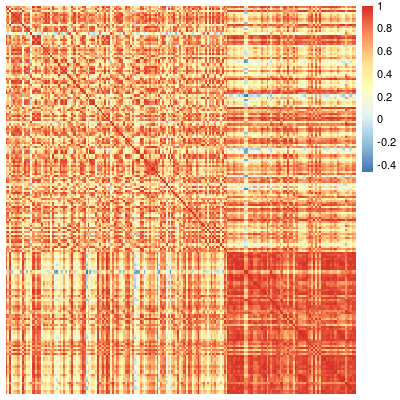

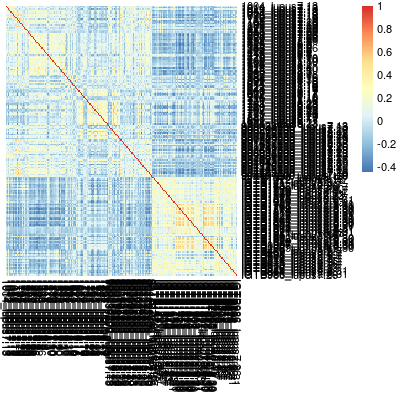

In [18]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F)

# Let's do some batch adjustments

## first, let's adjust cell type proportion

In [19]:
# cm_prop_mean = lm(cm_prop~1)$fitted;
# th_prop_mean = lm(th_prop~1)$fitted;
# b_prop_mean = lm(b_prop~1)$fitted;
# nk_prop_mean = lm(nk_prop~1)$fitted;
# ncm_prop_mean = lm(ncm_prop~1)$fitted;
# tc_prop_mean = lm(tc_prop~1)$fitted;
# dc_prop_mean = lm(dc_prop~1)$fitted;

# cm_prop = lm(cm_prop~joined_pivot$batch_cov)$residual+cm_prop_mean;
# th_prop = lm(th_prop~joined_pivot$batch_cov)$residual+th_prop_mean;
# b_prop = lm(b_prop~joined_pivot$batch_cov)$residual+b_prop_mean;
# nk_prop = lm(nk_prop~joined_pivot$batch_cov)$residual+nk_prop_mean;
# ncm_prop = lm(ncm_prop~joined_pivot$batch_cov)$residual+ncm_prop_mean;
# tc_prop = lm(tc_prop~joined_pivot$batch_cov)$residual+tc_prop_mean;
# dc_prop = lm(dc_prop~joined_pivot$batch_cov)$residual+dc_prop_mean;
props <- as.matrix(data.frame(cM=cm_prop, Th=th_prop, B=b_prop, NK=nk_prop, ncM=ncm_prop, Tc=tc_prop, DC=dc_prop));

# cm_sle_prop_mean = lm(cm_sle_prop~1)$fitted;
# th_sle_prop_mean = lm(th_sle_prop~1)$fitted;
# b_sle_prop_mean = lm(b_sle_prop~1)$fitted;
# ncm_sle_prop_mean = lm(ncm_sle_prop~1)$fitted;
# nk_sle_prop_mean = lm(nk_sle_prop~1)$fitted;
# tc_sle_prop_mean = lm(tc_sle_prop~1)$fitted;
# dc_sle_prop_mean = lm(dc_sle_prop~1)$fitted;

# cm_sle_prop = lm(cm_sle_prop~joined_pivot_sle$batch_cov)$residual+cm_sle_prop_mean;
# th_sle_prop = lm(th_sle_prop~joined_pivot_sle$batch_cov)$residual+th_sle_prop_mean;
# b_sle_prop = lm(b_sle_prop~joined_pivot_sle$batch_cov)$residual+b_sle_prop_mean;
# nk_sle_prop = lm(nk_sle_prop~joined_pivot_sle$batch_cov)$residual+nk_sle_prop_mean;
# ncm_sle_prop = lm(ncm_sle_prop~joined_pivot_sle$batch_cov)$residual+ncm_sle_prop_mean;
# tc_sle_prop = lm(tc_sle_prop~joined_pivot_sle$batch_cov)$residual+tc_sle_prop_mean;
# dc_sle_prop = lm(dc_sle_prop~joined_pivot_sle$batch_cov)$residual+dc_sle_prop_mean;
props_sle <- as.matrix(data.frame(cM=cm_sle_prop, Th=th_sle_prop, B=b_sle_prop, NK=nk_sle_prop, ncM=ncm_sle_prop, Tc=tc_sle_prop, DC=dc_sle_prop));


# cm_ucsf_healthy_prop_mean = lm(cm_ucsf_healthy_prop~1)$fitted;
# th_ucsf_healthy_prop_mean = lm(th_ucsf_healthy_prop~1)$fitted;
# b_ucsf_healthy_prop_mean = lm(b_ucsf_healthy_prop~1)$fitted;
# ncm_ucsf_healthy_prop_mean = lm(ncm_ucsf_healthy_prop~1)$fitted;
# nk_ucsf_healthy_prop_mean = lm(nk_ucsf_healthy_prop~1)$fitted;
# tc_ucsf_healthy_prop_mean = lm(tc_ucsf_healthy_prop~1)$fitted;
# dc_ucsf_healthy_prop_mean = lm(dc_ucsf_healthy_prop~1)$fitted;

# cm_ucsf_healthy_prop = lm(cm_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+cm_ucsf_healthy_prop_mean;
# th_ucsf_healthy_prop = lm(th_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+th_ucsf_healthy_prop_mean;
# b_ucsf_healthy_prop = lm(b_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+b_ucsf_healthy_prop_mean;
# nk_ucsf_healthy_prop = lm(nk_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+nk_ucsf_healthy_prop_mean;
# ncm_ucsf_healthy_prop = lm(ncm_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+ncm_ucsf_healthy_prop_mean;
# tc_ucsf_healthy_prop = lm(tc_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+tc_ucsf_healthy_prop_mean;
# dc_ucsf_healthy_prop = lm(dc_ucsf_healthy_prop~joined_pivot_ucsf_healthy$batch_cov)$residual+dc_ucsf_healthy_prop_mean;
props_ucsf_healthy <- as.matrix(data.frame(cM=cm_ucsf_healthy_prop, Th=th_ucsf_healthy_prop, B=b_ucsf_healthy_prop, NK=nk_ucsf_healthy_prop, ncM=ncm_ucsf_healthy_prop, Tc=tc_ucsf_healthy_prop, DC=dc_ucsf_healthy_prop));

# cm_broad_healthy_prop_mean = lm(cm_broad_healthy_prop~1)$fitted;
# th_broad_healthy_prop_mean = lm(th_broad_healthy_prop~1)$fitted;
# b_broad_healthy_prop_mean = lm(b_broad_healthy_prop~1)$fitted;
# ncm_broad_healthy_prop_mean = lm(ncm_broad_healthy_prop~1)$fitted;
# nk_broad_healthy_prop_mean = lm(nk_broad_healthy_prop~1)$fitted;
# tc_broad_healthy_prop_mean = lm(tc_broad_healthy_prop~1)$fitted;
# dc_broad_healthy_prop_mean = lm(dc_broad_healthy_prop~1)$fitted;

# cm_broad_healthy_prop = lm(cm_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+cm_broad_healthy_prop_mean;
# th_broad_healthy_prop = lm(th_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+th_broad_healthy_prop_mean;
# b_broad_healthy_prop = lm(b_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+b_broad_healthy_prop_mean;
# nk_broad_healthy_prop = lm(nk_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+nk_broad_healthy_prop_mean;
# ncm_broad_healthy_prop = lm(ncm_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+ncm_broad_healthy_prop_mean;
# tc_broad_healthy_prop = lm(tc_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+tc_broad_healthy_prop_mean;
# dc_broad_healthy_prop = lm(dc_broad_healthy_prop~joined_pivot_broad_healthy$batch_cov)$residual+dc_broad_healthy_prop_mean;
props_broad_healthy <- as.matrix(data.frame(cM=cm_broad_healthy_prop, Th=th_broad_healthy_prop, B=b_broad_healthy_prop, NK=nk_broad_healthy_prop, ncM=ncm_broad_healthy_prop, Tc=tc_broad_healthy_prop, DC=dc_broad_healthy_prop));


## second, let's adjust cell type specific expression

In [20]:
pbmc_mean <- t(lm(t(pbmc_expr)~1)$fitted)
cm_mean <- t(lm(t(cm_expr)~1)$fitted)
th_mean <- t(lm(t(th_expr)~1)$fitted)
b_mean <- t(lm(t(b_expr)~1)$fitted)
nk_mean <- t(lm(t(nk_expr)~1)$fitted)
ncm_mean <- t(lm(t(ncm_expr)~1)$fitted)
tc_mean <- t(lm(t(tc_expr)~1)$fitted)
dc_mean <- t(lm(t(dc_expr)~1)$fitted)

#joined_pivot$seq_batch_cov <- grep("immvar",joined_pivot$batch_cov)

# pbmc_expr <- t(lm(t(pbmc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$seq_batch_cov)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

modcombat = model.matrix(~disease_cov, data=joined_pivot);

pbmc_expr <- ComBat(dat=pbmc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
cm_expr <-  ComBat(dat=cm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
th_expr <-  ComBat(dat=th_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
b_expr <-  ComBat(dat=b_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
nk_expr <-  ComBat(dat=nk_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
ncm_expr <-  ComBat(dat=ncm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
tc_expr <-  ComBat(dat=tc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
dc_expr <-  ComBat(dat=dc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
               c(nrow(cm_expr) , ncol(cm_expr), 7),
               list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_expr <- t(lm(t(pbmc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~joined_pivot_filtered$batch_cov*joined_pivot_filtered$disease_cov)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


# pbmc_expr <- t(lm(t(pbmc_expr)~joined_pivot_filtered$batch_cov)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~joined_pivot_filtered$batch_cov)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~joined_pivot_filtered$batch_cov)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~joined_pivot_filtered$batch_cov)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~joined_pivot_filtered$batch_cov)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~joined_pivot_filtered$batch_cov)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~joined_pivot_filtered$batch_cov)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~joined_pivot_filtered$batch_cov)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_expr <- t(lm(t(pbmc_expr)~1)$residuals)+pbmc_mean
# cm_expr <- t(lm(t(cm_expr)~1)$residuals)+cm_mean
# th_expr <- t(lm(t(th_expr)~1)$residuals)+th_mean
# b_expr <- t(lm(t(b_expr)~1)$residuals)+b_mean
# nk_expr <- t(lm(t(nk_expr)~1)$residuals)+nk_mean
# ncm_expr <- t(lm(t(ncm_expr)~1)$residuals)+ncm_mean
# tc_expr <- t(lm(t(tc_expr)~1)$residuals)+tc_mean
# dc_expr <- t(lm(t(dc_expr)~1)$residuals)+dc_mean
# exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
#                c(nrow(cm_expr) , ncol(cm_expr), 7),
#                list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0
exprs_std <- array(c(cm_expr_std, th_expr_std, b_expr_std, nk_expr_std, ncm_expr_std, tc_expr_std, dc_expr_std),
                   c(nrow(cm_expr) , ncol(cm_expr), 7), 
                   list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_sle_mean <- t(lm(t(pbmc_sle_expr)~1)$fitted)
# cm_sle_mean <- t(lm(t(cm_sle_expr)~1)$fitted)
# th_sle_mean <- t(lm(t(th_sle_expr)~1)$fitted)
# b_sle_mean <- t(lm(t(b_sle_expr)~1)$fitted)
# nk_sle_mean <- t(lm(t(nk_sle_expr)~1)$fitted)
# ncm_sle_mean <- t(lm(t(ncm_sle_expr)~1)$fitted)
# tc_sle_mean <- t(lm(t(tc_sle_expr)~1)$fitted)
# dc_sle_mean <- t(lm(t(dc_sle_expr)~1)$fitted)

# pbmc_sle_expr <- t(lm(t(pbmc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+pbmc_sle_mean
# cm_sle_expr <- t(lm(t(cm_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+cm_sle_mean
# th_sle_expr <- t(lm(t(th_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+th_sle_mean
# b_sle_expr <- t(lm(t(b_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+b_sle_mean
# nk_sle_expr <- t(lm(t(nk_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+nk_sle_mean
# ncm_sle_expr <- t(lm(t(ncm_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+ncm_sle_mean
# tc_sle_expr <- t(lm(t(tc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+tc_sle_mean
# dc_sle_expr <- t(lm(t(dc_sle_expr)~joined_pivot_sle$batch_cov)$residuals)+dc_sle_mean
# exprs_sle <- array(c(cm_sle_expr, th_sle_expr, b_sle_expr, nk_sle_expr, ncm_sle_expr, tc_sle_expr, dc_sle_expr),
#                    c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
#                    list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]
exprs_sle <- array(c(cm_sle_expr, th_sle_expr, b_sle_expr, nk_sle_expr, ncm_sle_expr, tc_sle_expr, dc_sle_expr),
                       c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
                       list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_std <- t(apply(cm_sle_expr,1,standardize))
cm_sle_expr_std[is.na(cm_sle_expr_std)] <- 0
th_sle_expr_std <- t(apply(th_sle_expr,1,standardize))
th_sle_expr_std[is.na(th_sle_expr_std)] <- 0
b_sle_expr_std <- t(apply(b_sle_expr,1,standardize))
b_sle_expr_std[is.na(b_sle_expr_std)] <- 0
nk_sle_expr_std <- t(apply(nk_sle_expr,1,standardize))
nk_sle_expr_std[is.na(nk_sle_expr_std)] <- 0
ncm_sle_expr_std <- t(apply(ncm_sle_expr,1,standardize))
ncm_sle_expr_std[is.na(ncm_sle_expr_std)] <- 0
tc_sle_expr_std <- t(apply(tc_sle_expr,1,standardize))
tc_sle_expr_std[is.na(tc_sle_expr_std)] <- 0
dc_sle_expr_std <- t(apply(dc_sle_expr,1,standardize))
dc_sle_expr_std[is.na(dc_sle_expr_std)] <- 0
exprs_sle_std <- array(c(cm_sle_expr_std, th_sle_expr_std, b_sle_expr_std, nk_sle_expr_std, ncm_sle_expr_std, tc_sle_expr_std, dc_sle_expr_std),
                       c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
                       list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

# pbmc_ucsf_healthy_mean <- t(lm(t(pbmc_ucsf_healthy_expr)~1)$fitted)
# cm_ucsf_healthy_mean <- t(lm(t(cm_ucsf_healthy_expr)~1)$fitted)
# th_ucsf_healthy_mean <- t(lm(t(th_ucsf_healthy_expr)~1)$fitted)
# b_ucsf_healthy_mean <- t(lm(t(b_ucsf_healthy_expr)~1)$fitted)
# nk_ucsf_healthy_mean <- t(lm(t(nk_ucsf_healthy_expr)~1)$fitted)
# ncm_ucsf_healthy_mean <- t(lm(t(ncm_ucsf_healthy_expr)~1)$fitted)
# tc_ucsf_healthy_mean <- t(lm(t(tc_ucsf_healthy_expr)~1)$fitted)
# dc_ucsf_healthy_mean <- t(lm(t(dc_ucsf_healthy_expr)~1)$fitted)

# pbmc_ucsf_healthy_expr <- t(lm(t(pbmc_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+pbmc_ucsf_healthy_mean
# cm_ucsf_healthy_expr <- t(lm(t(cm_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+cm_ucsf_healthy_mean
# th_ucsf_healthy_expr <- t(lm(t(th_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+th_ucsf_healthy_mean
# b_ucsf_healthy_expr <- t(lm(t(b_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+b_ucsf_healthy_mean
# nk_ucsf_healthy_expr <- t(lm(t(nk_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+nk_ucsf_healthy_mean
# ncm_ucsf_healthy_expr <- t(lm(t(ncm_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+ncm_ucsf_healthy_mean
# tc_ucsf_healthy_expr <- t(lm(t(tc_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+tc_ucsf_healthy_mean
# dc_ucsf_healthy_expr <- t(lm(t(dc_ucsf_healthy_expr)~joined_pivot_ucsf_healthy$batch_cov)$residuals)+dc_ucsf_healthy_mean
# exprs_ucsf_healthy <- array(c(cm_ucsf_healthy_expr, th_ucsf_healthy_expr, b_ucsf_healthy_expr, nk_ucsf_healthy_expr, ncm_ucsf_healthy_expr, tc_ucsf_healthy_expr, dc_ucsf_healthy_expr),
#                        c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
#                        list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

cm_ucsf_healthy_expr <- cm_expr[,ucsf_healthy_indices]
th_ucsf_healthy_expr <- th_expr[,ucsf_healthy_indices]
tc_ucsf_healthy_expr <- tc_expr[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr <- ncm_expr[,ucsf_healthy_indices]
b_ucsf_healthy_expr <- b_expr[,ucsf_healthy_indices]
nk_ucsf_healthy_expr <- nk_expr[,ucsf_healthy_indices]
dc_ucsf_healthy_expr <- dc_expr[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]
exprs_ucsf_healthy <- array(c(cm_ucsf_healthy_expr, th_ucsf_healthy_expr, b_ucsf_healthy_expr, nk_ucsf_healthy_expr, ncm_ucsf_healthy_expr, tc_ucsf_healthy_expr, dc_ucsf_healthy_expr),
                           c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
                           list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_ucsf_healthy_expr_std <- t(apply(pbmc_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_std <- t(apply(cm_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_std[is.na(cm_ucsf_healthy_expr_std)] <- 0
th_ucsf_healthy_expr_std <- t(apply(th_ucsf_healthy_expr,1,standardize))
th_ucsf_healthy_expr_std[is.na(th_ucsf_healthy_expr_std)] <- 0
b_ucsf_healthy_expr_std <- t(apply(b_ucsf_healthy_expr,1,standardize))
b_ucsf_healthy_expr_std[is.na(b_ucsf_healthy_expr_std)] <- 0
nk_ucsf_healthy_expr_std <- t(apply(nk_ucsf_healthy_expr,1,standardize))
nk_ucsf_healthy_expr_std[is.na(nk_ucsf_healthy_expr_std)] <- 0
ncm_ucsf_healthy_expr_std <- t(apply(ncm_ucsf_healthy_expr,1,standardize))
ncm_ucsf_healthy_expr_std[is.na(ncm_ucsf_healthy_expr_std)] <- 0
tc_ucsf_healthy_expr_std <- t(apply(tc_ucsf_healthy_expr,1,standardize))
tc_ucsf_healthy_expr_std[is.na(tc_ucsf_healthy_expr_std)] <- 0
dc_ucsf_healthy_expr_std <- t(apply(dc_ucsf_healthy_expr,1,standardize))
dc_ucsf_healthy_expr_std[is.na(dc_ucsf_healthy_expr_std)] <- 0
exprs_ucsf_healthy_std <- array(c(cm_ucsf_healthy_expr_std, th_ucsf_healthy_expr_std, b_ucsf_healthy_expr_std, nk_ucsf_healthy_expr_std, ncm_ucsf_healthy_expr_std, tc_ucsf_healthy_expr_std, dc_ucsf_healthy_expr_std),
                           c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
                           list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


# pbmc_broad_healthy_mean <- t(lm(t(pbmc_broad_healthy_expr)~1)$fitted)
# cm_broad_healthy_mean <- t(lm(t(cm_broad_healthy_expr)~1)$fitted)
# th_broad_healthy_mean <- t(lm(t(th_broad_healthy_expr)~1)$fitted)
# b_broad_healthy_mean <- t(lm(t(b_broad_healthy_expr)~1)$fitted)
# nk_broad_healthy_mean <- t(lm(t(nk_broad_healthy_expr)~1)$fitted)
# ncm_broad_healthy_mean <- t(lm(t(ncm_broad_healthy_expr)~1)$fitted)
# tc_broad_healthy_mean <- t(lm(t(tc_broad_healthy_expr)~1)$fitted)
# dc_broad_healthy_mean <- t(lm(t(dc_broad_healthy_expr)~1)$fitted)

# pbmc_broad_healthy_expr <- t(lm(t(pbmc_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+pbmc_broad_healthy_mean
# cm_broad_healthy_expr <- t(lm(t(cm_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+cm_broad_healthy_mean
# th_broad_healthy_expr <- t(lm(t(th_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+th_broad_healthy_mean
# b_broad_healthy_expr <- t(lm(t(b_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+b_broad_healthy_mean
# nk_broad_healthy_expr <- t(lm(t(nk_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+nk_broad_healthy_mean
# ncm_broad_healthy_expr <- t(lm(t(ncm_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+ncm_broad_healthy_mean
# tc_broad_healthy_expr <- t(lm(t(tc_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+tc_broad_healthy_mean
# dc_broad_healthy_expr <- t(lm(t(dc_broad_healthy_expr)~joined_pivot_broad_healthy$batch_cov)$residuals)+dc_broad_healthy_mean
# exprs_broad_healthy <- array(c(cm_broad_healthy_expr, th_broad_healthy_expr, b_broad_healthy_expr, nk_broad_healthy_expr, ncm_broad_healthy_expr, tc_broad_healthy_expr, dc_broad_healthy_expr),
#                        c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
#                        list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

cm_broad_healthy_expr <- cm_expr[,broad_healthy_indices]
th_broad_healthy_expr <- th_expr[,broad_healthy_indices]
tc_broad_healthy_expr <- tc_expr[,broad_healthy_indices]
ncm_broad_healthy_expr <- ncm_expr[,broad_healthy_indices]
b_broad_healthy_expr <- b_expr[,broad_healthy_indices]
nk_broad_healthy_expr <- nk_expr[,broad_healthy_indices]
dc_broad_healthy_expr <- dc_expr[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]
exprs_broad_healthy <- array(c(cm_broad_healthy_expr, th_broad_healthy_expr, b_broad_healthy_expr, nk_broad_healthy_expr, ncm_broad_healthy_expr, tc_broad_healthy_expr, dc_broad_healthy_expr),
                           c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
                           list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_broad_healthy_expr_std <- t(apply(pbmc_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_std <- t(apply(cm_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_std[is.na(cm_broad_healthy_expr_std)] <- 0
th_broad_healthy_expr_std <- t(apply(th_broad_healthy_expr,1,standardize))
th_broad_healthy_expr_std[is.na(th_broad_healthy_expr_std)] <- 0
b_broad_healthy_expr_std <- t(apply(b_broad_healthy_expr,1,standardize))
b_broad_healthy_expr_std[is.na(b_broad_healthy_expr_std)] <- 0
nk_broad_healthy_expr_std <- t(apply(nk_broad_healthy_expr,1,standardize))
nk_broad_healthy_expr_std[is.na(nk_broad_healthy_expr_std)] <- 0
ncm_broad_healthy_expr_std <- t(apply(ncm_broad_healthy_expr,1,standardize))
ncm_broad_healthy_expr_std[is.na(ncm_broad_healthy_expr_std)] <- 0
tc_broad_healthy_expr_std <- t(apply(tc_broad_healthy_expr,1,standardize))
tc_broad_healthy_expr_std[is.na(tc_broad_healthy_expr_std)] <- 0
dc_broad_healthy_expr_std <- t(apply(dc_broad_healthy_expr,1,standardize))
dc_broad_healthy_expr_std[is.na(dc_broad_healthy_expr_std)] <- 0
exprs_broad_healthy_std <- array(c(cm_broad_healthy_expr_std, th_broad_healthy_expr_std, b_broad_healthy_expr_std, nk_broad_healthy_expr_std, ncm_broad_healthy_expr_std, tc_broad_healthy_expr_std, dc_broad_healthy_expr_std),
                           c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
                           list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



## plot both

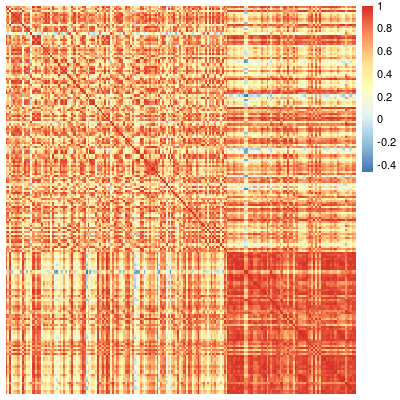

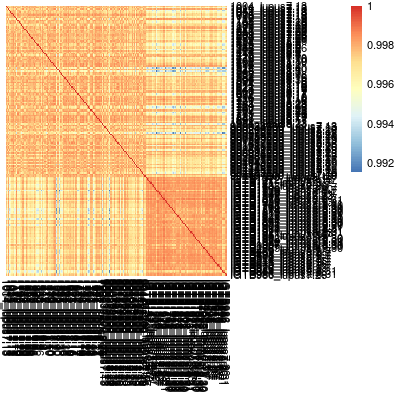

In [21]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr)),cluster_rows=F,cluster_cols=F)

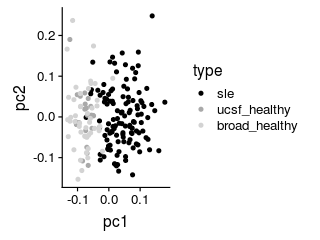

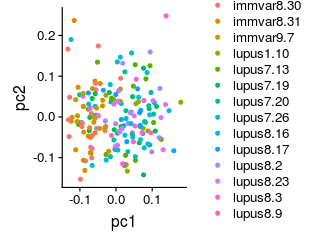

In [22]:
##pbmc_expr_prcomp <- prcomp(pbmc_expr)
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

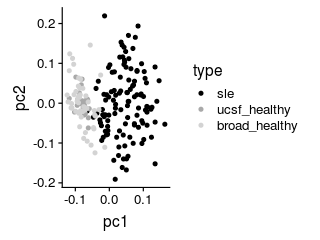

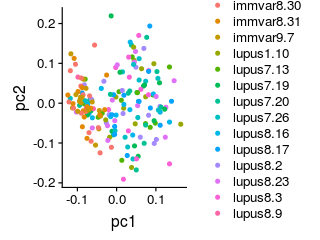

In [23]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(deseq_sig_genes,rownames(pbmc_expr_std))),])

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

# Figure 2A - heatmap

In [24]:
pbmc_col_clust <- hclust(dist(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]),method = "euclidean"), method="ward.D")
pbmc_row_clust <- hclust(dist(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],method = "euclidean"), method="ward.D")

all_expr <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr[,pbmc_col_clust$order],
                      ncm=ncm_expr[,pbmc_col_clust$order],
                      dc=dc_expr[,pbmc_col_clust$order],
                      th=th_expr[,pbmc_col_clust$order],
                      tc=tc_expr[,pbmc_col_clust$order],
                       nk=nk_expr[,pbmc_col_clust$order],
                      b=b_expr[,pbmc_col_clust$order]
                      )
all_expr_sig <- all_expr[match(deseq_sig_genes,expr_gene_names),]

all_expr_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                      cm=cm_expr_std[,pbmc_col_clust$order],
                      ncm=ncm_expr_std[,pbmc_col_clust$order],
                      dc=dc_expr_std[,pbmc_col_clust$order],
                      th=th_expr_std[,pbmc_col_clust$order],
                      tc=tc_expr_std[,pbmc_col_clust$order],
                       nk=nk_expr_std[,pbmc_col_clust$order],
                      b=b_expr_std[,pbmc_col_clust$order]
                      )

all_expr_std_sig <- all_expr_std[match(deseq_sig_genes,expr_gene_names),]

ct_annotation_one <- data.frame(disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation_one) <- colnames(pbmc_expr);

ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
#                            disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),
#                                                 rep("ctrl",ncol(cm_healthy_expr)))[pbmc_clust$order],
#                                               length(cell_types))),
                           disease_pop_cov=joined_pivot$disease_pop_cov[pbmc_col_clust$order],
                           sledaiscore=joined_pivot$sledaiscore[pbmc_col_clust$order])
rownames(ct_annotation) <- colnames(all_expr_std);


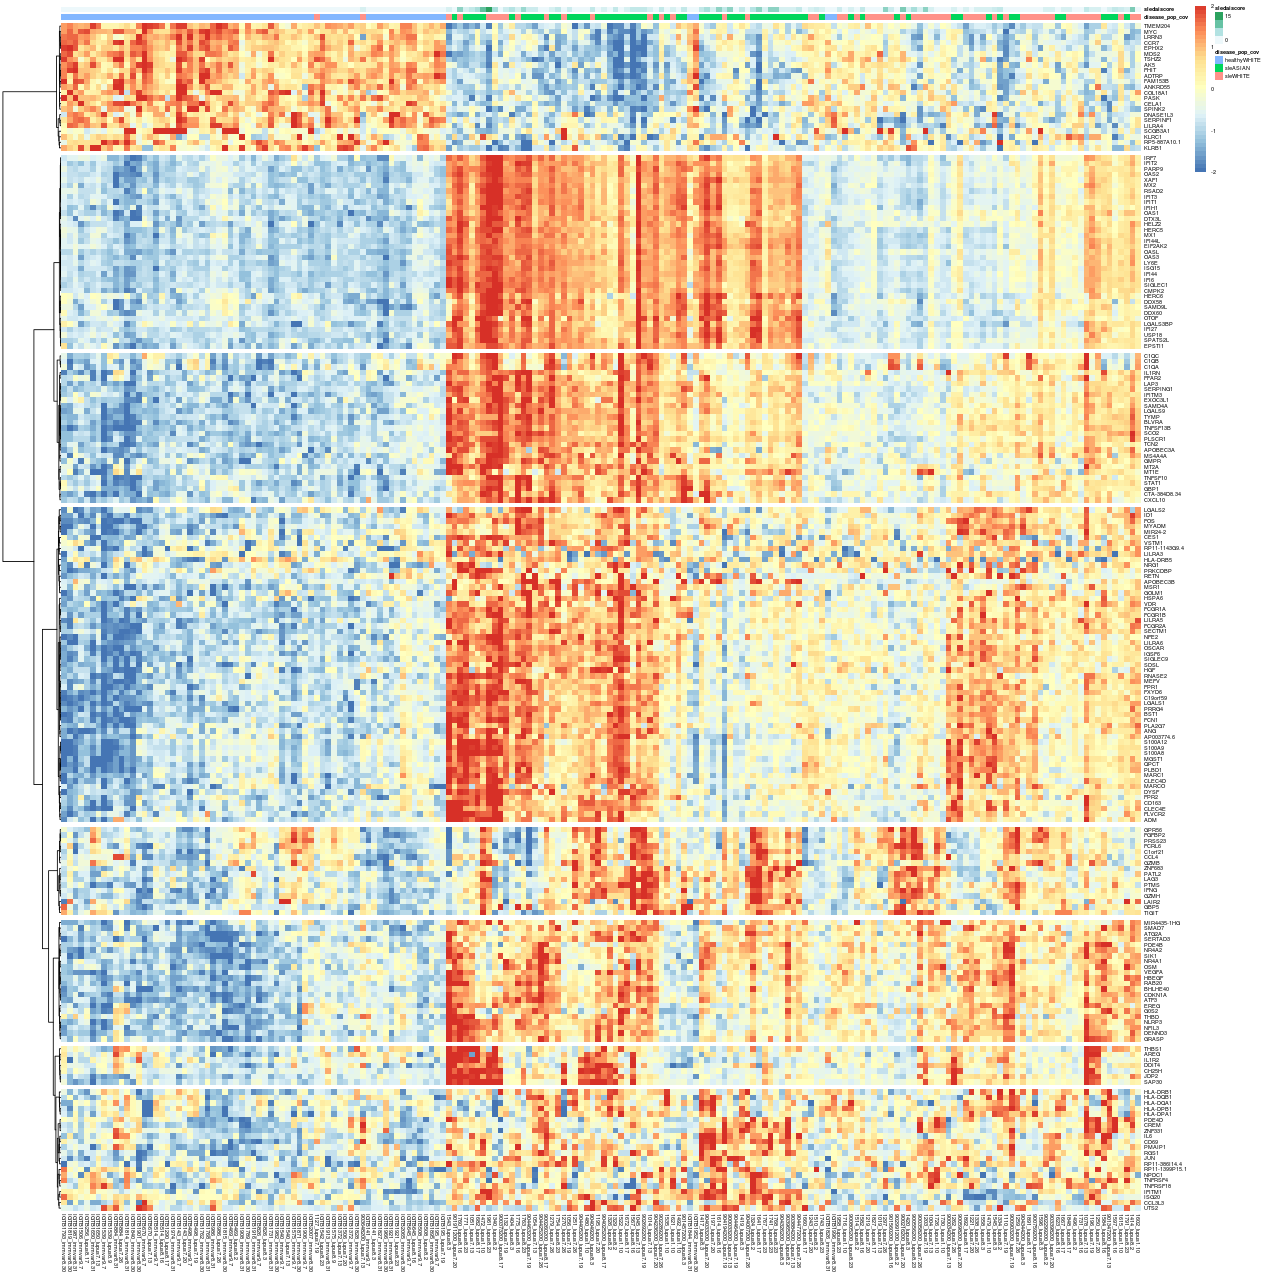

In [25]:
options(repr.plot.width = 16, repr.plot.height = 16)

breaksList = seq(-2, 2, by = .1)
pheatmap_out <- pheatmap(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
         cluster_rows=T, cluster_cols=F,annotation_col = ct_annotation_one[pbmc_col_clust$order,],#annotation_row = kmeans_annotation,
         color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), 
                         cutree_rows=8, 
                         scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",# Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
        breaks = breaksList) # Sets the breaks of the color scale as in breaksList

In [26]:
print(dim(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order]))

[1] 209 188


In [27]:
ifn_crow <- read.table("ifn.lupus.crow.etal.txt")
crow_annotation <- matrix(nrow=nrow(all_expr_std_sig), ncol=1, 0);
crow_annotation[na.omit(match(ifn_crow$V1, rownames(all_expr_std_sig))),1] <- 1;
rownames(crow_annotation) <- rownames(all_expr_std_sig)
colnames(crow_annotation) <- "Crow"
crow_annotation <- as.data.frame(crow_annotation)

In [28]:
sum(crow_annotation$Crow)

[1] 25

In [29]:
pbmc_deseq_sig_annotation <- matrix(nrow=nrow(all_expr_std_sig), ncol=1, 0);
pbmc_deseq_sig_annotation[na.omit(match(pbmc_deseq_sig_genes, rownames(all_expr_std_sig))),1] <- 1;
rownames(pbmc_deseq_sig_annotation) <- rownames(all_expr_std_sig)
colnames(pbmc_deseq_sig_annotation) <- "PBMC Sig"
pbmc_deseq_sig_annotation <- as.data.frame(pbmc_deseq_sig_annotation)

In [30]:
dim(pbmc_deseq_sig_annotation)
length(pbmc_deseq_sig_genes)

[1] 209   1

[1] 149

In [31]:
row_annotations <- cbind(crow_annotation, pbmc_deseq_sig_annotation)

In [32]:
sum(row_annotations$Crow[row_annotations$"PBMC Sig"==1])

[1] 21

In [33]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2, 2, by = .2)

# pheatmap_std_out <- pheatmap(all_expr_std_sig,
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, #annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr),ncol(cm_expr)*length(cell_types),ncol(cm_expr)),
#                          cutree_rows=8, 
#                          scale="none",fontsize=2,clustering_method="ward.D",clustering_distance_row="manhattan", filename="expr_std_heatmap.png",
#                             width=10, height=10, dpi=600)
# options(repr.plot.width = 10, repr.plot.height = 4)



In [34]:
joined_full=read.table('../figure1.ct.diff/CLUESImmVar_processed.V6_joined_pivot_cg_perc.txt', sep=',', header=T)
print(head(joined_full))
pbmc_use=pbmc_expr_std[match(pbmc_deseq_sig_genes,expr_gene_names),pbmc_col_clust$order]

inds=sapply(strsplit(colnames(pbmc_use),'_'), '[', 1)

joined_full_use=joined_full[match(inds, joined_full[['ind_cov']]), ]

sig=prcomp(t(pbmc_use))$x[, 1]


sig.sle=sig[grep('IGTB', names(sig), invert=T)]
joined_full_sle=joined_full_use[grep('IGTB', names(sig), invert=T), ]


#correlation with sledaiscore
cor(joined_full_sle[['sledaiscore']], sig.sle, use = 'complete.obs')

#correlation with mono and lymph
cor(joined_full_sle[['PercMono']], sig.sle, use = 'complete.obs')
cor(joined_full_sle[['PercLympho']], sig.sle, use = 'complete.obs')



  X ind_cov subjectid  pbmc disease_cov disease_pop_cov disease_pop_site_cov
1 0    1004      1004 1.674         sle        sleWHITE         sleWHITEUCSF
2 1    1014      1014 1.628         sle        sleWHITE         sleWHITEUCSF
3 2    1019      1019 1.845         sle        sleWHITE         sleWHITEUCSF
4 3    1045      1045 2.170         sle        sleASIAN         sleASIANUCSF
5 4    1051      1051 1.325         sle        sleASIAN         sleASIANUCSF
6 5    1054      1054 2.169         sle        sleASIAN         sleASIANUCSF
  batch_cov plaquenilnow cellceptnow steroralnow acrlymphopenia sledaiscore
1 lupus7.13            1           0           0              1           2
2 lupus7.13            1           0           1              0           2
3 lupus7.13            1           0           0              0           0
4 lupus7.13            1           0           1              0           4
5 lupus7.13            1           1           1              0           4
6 lup

[1] 0.1942172

[1] 0.5807265

[1] -0.2246171

## prediction 

In [79]:
#do LOO Cross Validation and return the predicted values

loo_cv <- function(mat_expr, outcome){
    k <- nrow(sledai)
    predictions <- c()
    for (i in 1:k) {
        model <- glmnet(mat_expr[-i,], outcome[-i])
        min_s=model$lambda[which.min(model$lambda)]
        p=predict(model, newx=t(as.matrix(mat_expr[i, ])), s=min_s)
        predictions <- c(predictions, p)                                  
        }
    return(predictions)
    }


In [104]:
library('glmnet')

# all_de=cv.glmnet(t(pbmc_expr_pred), sledai[['sledaiscore']], nfolds=nrow(sledai))

# min_error=which(all_de$glmnet.fit$lambda == all_de$lambda.min)
# r2 <- all_de$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_de$cvm/var(sledai[['sledaiscore']])
# rsq=rsq[min_error]
# print(r2)
# print(rsq)

# all_ifn=cv.glmnet(t(pbmc_ifn), sledai[['sledaiscore']], nfolds =nrow(sledai))

# min_error=which(all_ifn$glmnet.fit$lambda == all_ifn$lambda.min)
# r2 <- all_ifn$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_ifn$cvm/var(sledai[['sledaiscore']])
# rsq=rsq[min_error]
# print(r2)
# print(rsq)

# all_includect=cv.glmnet(t(all_includect_expr), sledai[['sledaiscore']], nfolds =  nrow(sledai))

# min_error=which(all_includect$glmnet.fit$lambda == all_includect$lambda.min)
# r2 <- all_includect$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_de$cvm/var(sledai[['sledaiscore']])
# rsq=rsq[min_error]
# print(r2)
# print(rsq)


pbmc_expr_pred=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order]
sledai=cbind(ct_annotation_one, joined_pivot[, 13:24])
sledai=sledai[pbmc_col_clust$order,]
print(head(sledai))

print(dim(sledai))
print(dim(pbmc_expr_pred))


pbmc_pred=loo_cv(t(pbmc_expr_pred), sledai[['sledaiscore']])

pbmc_ifn=pbmc_expr_pred[match(ifn_crow[['V1']], rownames(pbmc_expr_pred)),  ]
pbmc_ifn=pbmc_ifn[!is.na(rownames(pbmc_ifn)), ]

ifn_pred=loo_cv(t(pbmc_ifn), sledai[['sledaiscore']])

#now include CT composition featuers
all_includect_expr=rbind(pbmc_expr_pred, t(sledai[,3:ncol(sledai)]))
all_includect_expr=all_includect_expr[complete.cases(all_includect_expr), ]
#print(head(all_includect_expr))


pbmc_ct_comp_pred=loo_cv(t(all_includect_expr), sledai[['sledaiscore']])

                    disease_pop_cov sledaiscore         B        DB         MK
IGTB1793_immvar8.30    healthyWHITE           0  7.447062 0.6899833 0.07137759
IGTB1819_immvar8.30    healthyWHITE           0 12.467260 0.6809848 0.07857517
IGTB1987_immvar8.31    healthyWHITE           0 12.053708 1.0375343 0.12206286
IGTB1506_immvar9.7     healthyWHITE           0 12.899065 0.6772009 0.06449532
IGTB256_lupus8.17      healthyWHITE           0 14.581844 1.7155111         NA
IGTB1650_immvar8.31    healthyWHITE           0 11.929057 0.7288630 0.04859086
                           NK    Progen   ProlifT       Tc       Th       cDC
IGTB1793_immvar8.30  7.661194 0.6899833 0.4758506 28.62241 36.83084 1.4751368
IGTB1819_immvar8.30  7.176532 0.8381351 0.2619172 27.26558 34.33735 0.8381351
IGTB1987_immvar8.31  4.974062 0.7934086 0.1830943 20.47605 37.90052 0.7934086
IGTB1506_immvar9.7  10.029023 0.4514673 0.3224766 21.70268 32.63463 1.2254112
IGTB256_lupus8.17    7.791279 0.5003574 0.1429593 20.4431

In [114]:
#prediction with all cts
print(dim(all_expr_std_sig))
print(head(ct_annotation))

genes_use=setdiff(deseq_sig_genes, pbmc_deseq_sig_genes)
print(length(genes_use))

ifn_genes_use=intersect(ifn_crow[['V1']] , expr_gene_names)
all_expr_cts_ifn <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
                      cm=cm_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      ncm=ncm_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      dc=dc_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      th=th_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      tc=tc_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                       nk=nk_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      b=b_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order]
                      )



all_expr_cts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
                      cm=cm_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      ncm=ncm_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      dc=dc_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      th=th_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      tc=tc_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                       nk=nk_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      b=b_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order]
                      )
# all_de_cts=cv.glmnet(t(all_expr_cts), sledai[['sledaiscore']], nfolds=nrow(sledai))

# min_error=which(all_de_cts$glmnet.fit$lambda == all_de_cts$lambda.min)
# r2 <- all_de_cts$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_de$cvm/var(sledai[['sledaiscore']])
# #rsq=rsq[min_error]
# print(r2)
# print(rsq[min_error])


#LOO CV get predictions this time
ct_expr_pred=loo_cv(t(all_expr_cts), sledai[['sledaiscore']])
ct_expr_pred_ifn=loo_cv(t(all_expr_cts_ifn), sledai[['sledaiscore']])

##add the CT comp to CT expr
all_includect_comp_expr=rbind(all_expr_cts, t(sledai[,3:ncol(sledai)]))
all_includect_comp_expr=all_includect_comp_expr[complete.cases(all_includect_comp_expr), ]

ct_expr_ct_comp_pred=loo_cv(t(all_includect_comp_expr), sledai[['sledaiscore']])


[1]  209 1504
                         type disease_pop_cov sledaiscore
pbmc.IGTB1793_immvar8.30 PBMC    healthyWHITE           0
pbmc.IGTB1819_immvar8.30 PBMC    healthyWHITE           0
pbmc.IGTB1987_immvar8.31 PBMC    healthyWHITE           0
pbmc.IGTB1506_immvar9.7  PBMC    healthyWHITE           0
pbmc.IGTB256_lupus8.17   PBMC    healthyWHITE           0
pbmc.IGTB1650_immvar8.31 PBMC    healthyWHITE           0
[1] 60


Warning message in roc.default(sledai[["sledaiscore"]], pbmc_pred):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(sledai[["sledaiscore"]], ifn_pred):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(sledai[["sledaiscore"]], ct_expr_pred):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(sledai[["sledaiscore"]], ct_expr_pred_ifn):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: cont

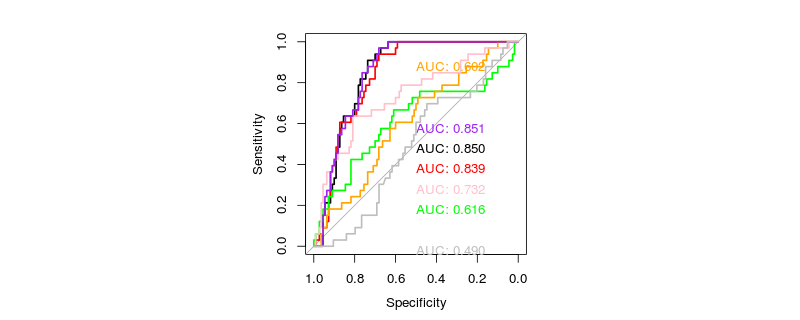

In [115]:
library(pROC)

load('plink_sledai_lm_roc.RData')


#pdf('sledaiscore.prediction.pdf')
par(pty="s")
plot(roc(sledai[['sledaiscore']], pbmc_pred), print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], ifn_pred), col='red', add =T, print.auc.y = .4, print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], ct_expr_pred), col='green', add =T, print.auc.y = .2, print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], ct_expr_pred_ifn), col='orange', add =T, print.auc.y = .9, print.auc=TRUE)

plot(roc(sledai[['sledaiscore']], ct_expr_ct_comp_pred), col='pink', add =T, print.auc.y = .3, print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], pbmc_ct_comp_pred ), col='purple', add =T, print.auc.y = .6, print.auc=TRUE)
plot(roc.obj, col='grey', add =T, print.auc.y = 0, print.auc=TRUE)

#dev.off()

In [107]:
#predict case/control status 

sledai[['disease']]=1
sledai[['disease']][grep('healthy', sledai[['disease_pop_cov']])]=0

ifn_pred=loo_cv(t(pbmc_ifn), sledai[['disease']])
pbmc_pred=loo_cv(t(pbmc_expr_pred), sledai[['disease']])
pbmc_ct_comp_pred=loo_cv(t(all_includect_expr), sledai[['disease']])
ct_expr_pred=loo_cv(t(all_expr_cts), sledai[['disease']])
ct_expr_ct_comp_pred=loo_cv(t(all_includect_comp_expr), sledai[['disease']])


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


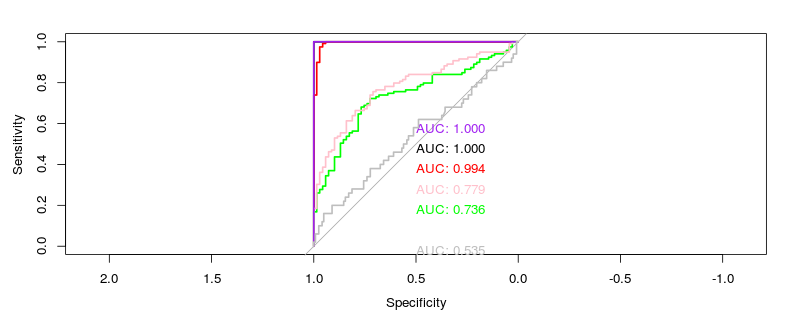

In [116]:
#pdf('disease.status.prediction.pdf')
load('plink_case_control_lm_roc.RData')
plot(roc(sledai[['disease']], pbmc_pred), print.auc=TRUE)
plot(roc(sledai[['disease']], ifn_pred), col='red', add =T, print.auc.y = .4, print.auc=TRUE)
plot(roc(sledai[['disease']], ct_expr_pred), col='green', add =T, print.auc.y = .2, print.auc=TRUE)
plot(roc(sledai[['disease']], ct_expr_ct_comp_pred), col='pink', add =T, print.auc.y = .3, print.auc=TRUE)
plot(roc(sledai[['disease']], pbmc_ct_comp_pred ), col='purple', add =T, print.auc.y = .6, print.auc=TRUE)

plot(roc.obj, col='grey', add =T, print.auc.y = 0, print.auc=TRUE)

#dev.off()

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


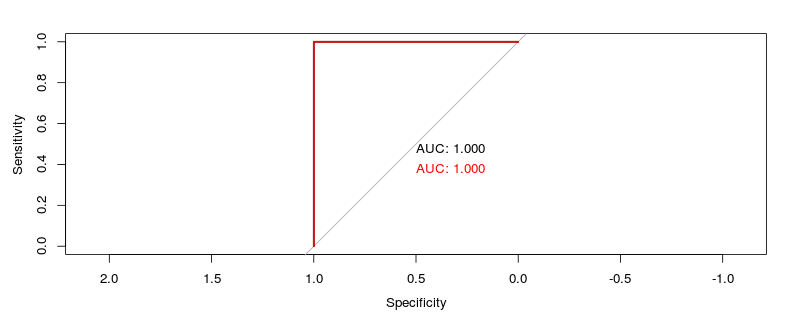

In [117]:
#ty prediction from full expression
pbmc_expr_full=pbmc_expr_std[,pbmc_col_clust$order]
all_includect_full=rbind(pbmc_expr_full, t(sledai[,3:ncol(sledai)]))
all_includect_full=all_includect_full[complete.cases(all_includect_full), ]

all_expr_cts_full <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
                      cm=cm_expr_std[,pbmc_col_clust$order],
                      ncm=ncm_expr_std[,pbmc_col_clust$order],
                      dc=dc_expr_std[,pbmc_col_clust$order],
                      th=th_expr_std[,pbmc_col_clust$order],
                      tc=tc_expr_std[,pbmc_col_clust$order],
                       nk=nk_expr_std[,pbmc_col_clust$order],
                      b=b_expr_std[,pbmc_col_clust$order]
                      )

all_expr_cts_perc_full=rbind(all_expr_cts_full, t(sledai[,3:ncol(sledai)]))
all_expr_cts_perc_full=all_expr_cts_perc_full[complete.cases(all_expr_cts_perc_full), ]


pbmc_full_pred=loo_cv(t(pbmc_expr_full), sledai[['disease']])
pbmc_full_includect_pred=loo_cv(t(all_includect_full), sledai[['disease']])


plot(roc(sledai[['disease']], pbmc_full_pred), print.auc=TRUE)
plot(roc(sledai[['disease']], pbmc_full_includect_pred), col='red', add =T, print.auc.y = .4, print.auc=TRUE)



